# TASK 1

In [91]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from textblob import TextBlob
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [92]:
df = pd.read_csv("Reviews.csv")

df = df[['Text', 'Score']]

In [93]:
def get_sentiment(score):
    if score <= 2:
        return 'negative'
    elif score == 3:
        return 'neutral'
    else:
        return 'positive'

In [94]:
df['Sentiment'] = df['Score'].apply(get_sentiment)

df = df[['Text', 'Sentiment']]

train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['Sentiment'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['Sentiment'], random_state=42)

print(f"Training set: {train_df.shape}")
print(f"Validation set: {val_df.shape}")
print(f"Test set: {test_df.shape}")

Training set: (454763, 2)
Validation set: (56845, 2)
Test set: (56846, 2)


In [95]:
stop_words = set(stopwords.words('english'))

lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
    lemmas = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(lemmas)

train_df['Clean_Text'] = train_df['Text'].apply(preprocess_text)
val_df['Clean_Text'] = val_df['Text'].apply(preprocess_text)
test_df['Clean_Text'] = test_df['Text'].apply(preprocess_text)

In [96]:
vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(train_df['Clean_Text'])
X_val = vectorizer.transform(val_df['Clean_Text'])
X_test = vectorizer.transform(test_df['Clean_Text'])

def get_sentiment_score(text):
    return TextBlob(text).sentiment.polarity

train_df['Sentiment_Score'] = train_df['Clean_Text'].apply(get_sentiment_score)
val_df['Sentiment_Score'] = val_df['Clean_Text'].apply(get_sentiment_score)
test_df['Sentiment_Score'] = test_df['Clean_Text'].apply(get_sentiment_score)


In [97]:
print("TF-IDF shape (train):", X_train.shape)
print("TF-IDF shape (val):", X_val.shape)
print("TF-IDF shape (test):", X_test.shape)

print("\nLexicon-based sentiment score examples:")
train_df[['Clean_Text', 'Sentiment_Score']].head()

TF-IDF shape (train): (454763, 86721)
TF-IDF shape (val): (56845, 86721)
TF-IDF shape (test): (56846, 86721)

Lexicon-based sentiment score examples:


,Clean_Text,Sentiment_Score
138428,like good fiber plenty protein good price thin...,0.352083
199827,purchased two leaf bud tea many time year say ...,0.204713
361105,two girl love training treat looking akc liver...,0.500000
382822,purchased soda stream cola mix seemed natural ...,0.450000
20633,plan writing review product mean dog food eat ...,-0.070410


In [98]:
def classify_by_threshold(score):
    if score > 0.1:
        return 'positive'
    elif score < -0.1:
        return 'negative'
    else:
        return 'neutral'

train_df['Pred_Sentiment'] = train_df['Sentiment_Score'].apply(classify_by_threshold)
val_df['Pred_Sentiment'] = val_df['Sentiment_Score'].apply(classify_by_threshold)
test_df['Pred_Sentiment'] = test_df['Sentiment_Score'].apply(classify_by_threshold)

y_train = train_df['Sentiment']
y_val = val_df['Sentiment']
y_test = test_df['Sentiment']

model = LogisticRegression()
model.fit(X_train, y_train)

val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Lexicon-based Accuracy (Test): 0.7134011188122296
Lexicon-based Accuracy (Validation): 0.7145923124285337
Lexicon-based Classification Report (Validation):
              precision    recall  f1-score   support

    negative       0.62      0.20      0.31      8203
     neutral       0.13      0.31      0.18      4264
    positive       0.86      0.85      0.86     44378

    accuracy                           0.71     56845
   macro avg       0.54      0.45      0.45     56845
weighted avg       0.77      0.71      0.73     56845



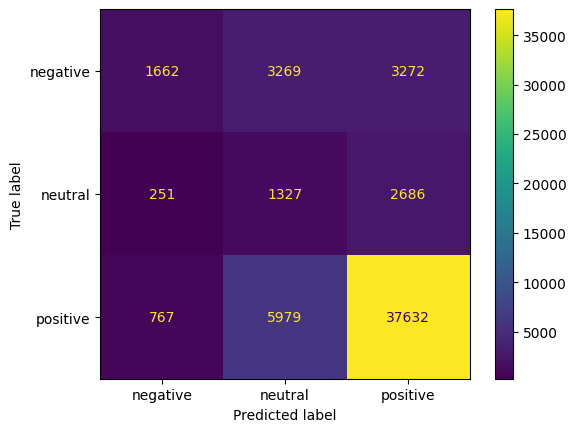

In [99]:
print("Lexicon-based Accuracy (Test):", accuracy_score(test_df['Sentiment'], test_df['Pred_Sentiment']))
print("Lexicon-based Accuracy (Validation):", accuracy_score(val_df['Sentiment'], val_df['Pred_Sentiment']))
print("Lexicon-based Classification Report (Validation):")
print(classification_report(val_df['Sentiment'], val_df['Pred_Sentiment']))

ConfusionMatrixDisplay(confusion_matrix(val_df['Sentiment'], val_df['Pred_Sentiment']), display_labels=['negative','neutral','positive']).plot()

Logistic Regression Accuracy (Text): 0.8714421419273124
Logistic Regression Accuracy (Validation): 0.8714750637699006
Classification Report (Validation):
              precision    recall  f1-score   support

    negative       0.74      0.69      0.72      8203
     neutral       0.55      0.21      0.30      4264
    positive       0.90      0.97      0.93     44378

    accuracy                           0.87     56845
   macro avg       0.73      0.62      0.65     56845
weighted avg       0.85      0.87      0.86     56845



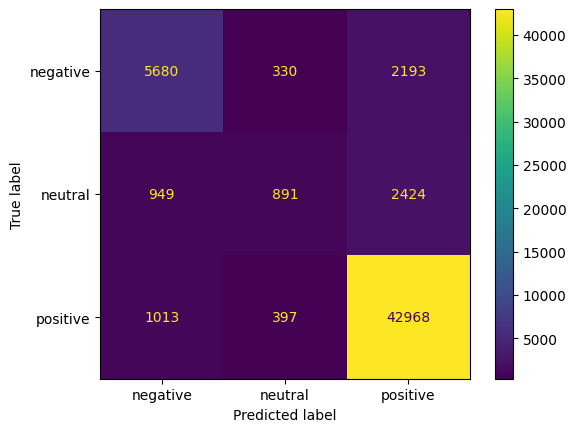

In [100]:
print("Logistic Regression Accuracy (Text):", accuracy_score(y_test, test_pred))
print("Logistic Regression Accuracy (Validation):", accuracy_score(y_val, val_pred))
print("Classification Report (Validation):")
print(classification_report(y_val, val_pred))

ConfusionMatrixDisplay(confusion_matrix(y_val, val_pred), display_labels=model.classes_).plot()

In [101]:
lex_errors = val_df[val_df['Sentiment'] != val_df['Pred_Sentiment']][['Text', 'Sentiment', 'Pred_Sentiment', 'Sentiment_Score']]

lex_errors.head()

,Text,Sentiment,Pred_Sentiment,Sentiment_Score
218667,"not good, better than nothing, I suppose.<br /...",negative,positive,0.150000
54871,I have been ordering these small dog treats fo...,positive,neutral,0.062406
331052,Kellogg's cereals contains genetically modifi...,negative,neutral,0.068143
182048,This is always what I reach for when congested...,positive,negative,-0.150000
393829,"I bought this almost a month ago and my dog, a...",positive,neutral,-0.012500


In [102]:
val_df['Pred_LogReg'] = val_pred
log_errors = val_df[val_df['Sentiment'] != val_df['Pred_LogReg']][['Text', 'Sentiment', 'Pred_LogReg']]

log_errors.head()

,Text,Sentiment,Pred_LogReg
163418,My Cat just loves Fancy Feast foods. She refus...,positive,negative
146015,"Like a lot of consumers, I purchased this coff...",neutral,positive
143133,You can feel that the pods are too loosely pac...,negative,positive
178644,I searched the web looking for a product that ...,positive,negative
413745,BBQ was out-of-stock when our subscription ord...,neutral,positive


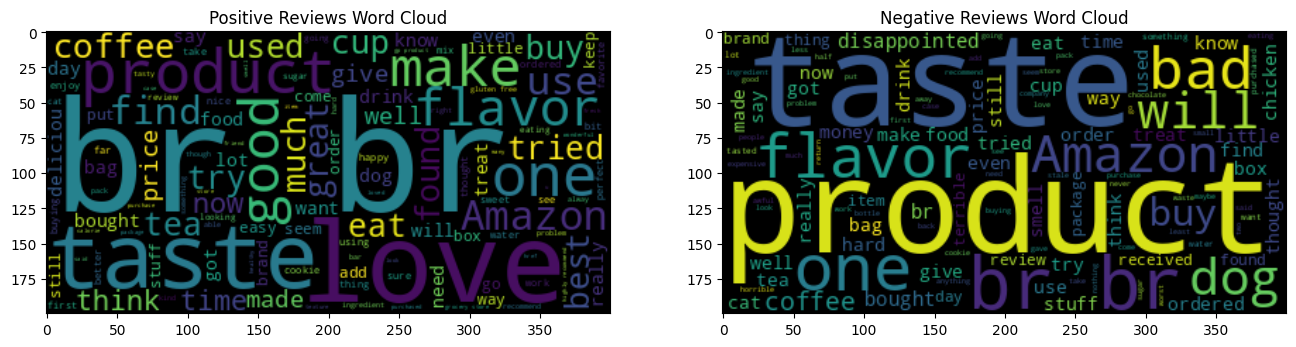

In [103]:
positive_text = " ".join(train_df[train_df['Pred_Sentiment']=='positive']['Text'])
negative_text = " ".join(train_df[train_df['Pred_Sentiment']=='negative']['Text'])

wc_pos = WordCloud().generate(positive_text)
wc_neg = WordCloud().generate(negative_text)

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.imshow(wc_pos, interpolation='bilinear')
plt.title("Positive Reviews Word Cloud")

plt.subplot(1,2,2)
plt.imshow(wc_neg, interpolation='bilinear')
plt.title("Negative Reviews Word Cloud")
plt.show()

In [104]:
feature_names = vectorizer.get_feature_names_out()
coefficients = model.coef_[2]

top_positive_idx = np.argsort(coefficients)[-20:]
top_negative_idx = np.argsort(coefficients)[:20]

top_positive_words = [(feature_names[i], coefficients[i]) for i in top_positive_idx]
top_negative_words = [(feature_names[i], coefficients[i]) for i in top_negative_idx]

print("Top Positive Words:")
print(pd.DataFrame(top_positive_words, columns=['Word', 'Weight']))

print("\nTop Negative Words:")
print(pd.DataFrame(top_negative_words, columns=['Word', 'Weight']))


Top Positive Words:
          Word    Weight
0     terrific  4.527340
1    perfectly  4.719886
2     addicted  4.784090
3      pleased  4.846309
4         beat  4.847110
5    wonderful  4.943387
6      awesome  5.031348
7        yummy  5.051663
8      amazing  5.293493
9    excellent  5.468052
10         yum  5.673216
11  pleasantly  6.129303
12        love  6.158660
13     perfect  6.220390
14   skeptical  6.236203
15        best  6.901528
16   delicious  6.996058
17      highly  7.382651
18      hooked  7.412769
19       great  7.543091

Top Negative Words:
              Word    Weight
0            worst -7.250928
1    disappointing -7.078346
2   disappointment -6.373559
3     disappointed -5.130747
4    unfortunately -5.090005
5         mediocre -5.010451
6          concept -4.845585
7            sadly -4.796403
8         terrible -4.718627
9          sounded -4.616038
10         lacking -4.471068
11              ok -4.379169
12           awful -4.171937
13            okay -4.142361

# TASK 2

In [105]:
files = ["article1.txt", "article2.txt", "article3.txt", "article4.txt", "article5.txt"]

articles = []
for file in files:
    with open(file, 'r', encoding='utf-8') as f:
        text = f.read()
        articles.append(text)

articles[0][:130]

'1. Introduction\nIn recent years, music plagiarism has become a \nserious issue in the music industry. With growing use\nof the World'

In [106]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text_to_sentences(text):
    sentences = sent_tokenize(text)
    cleaned_sentences = []

    for sentence in sentences:
        sentence = sentence.lower()

        tokens = word_tokenize(sentence)

        lemmas = [
            lemmatizer.lemmatize(t)
            for t in tokens
            if t not in stop_words and t.isalpha()
        ]

        cleaned_sentence = ' '.join(lemmas)

        if cleaned_sentence.strip():
            cleaned_sentences.append(cleaned_sentence)

    return cleaned_sentences


cleaned_articles = [preprocess_text_to_sentences(article) for article in articles]
cleaned_articles[0][:3]

['introduction recent year music plagiarism become serious issue music industry',
 'growing use world wide web revenue loss due plagiarism pirate copy escalating exponentially',
 'korea estimated billion dollar']

In [107]:
def calculate_sentence_importance(cleaned_sentences):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(cleaned_sentences)
    sentence_scores = tfidf_matrix.sum(axis=1)
    return sentence_scores

def extract_top_sentences(cleaned_sentences, sentence_scores, num_sentences=3):
    sentence_scores = np.array(sentence_scores).flatten()
    ranked_sentence_indices = sentence_scores.argsort()[::-1]
    top_sentence_indices = ranked_sentence_indices[:num_sentences]
    top_sentences = [cleaned_sentences[i] for i in top_sentence_indices]
    return top_sentences

In [108]:
top_sentences_per_article = []
for article in cleaned_articles:
    if article:
        article_sentence_scores = calculate_sentence_importance(article)
        top_sentences_per_article.append(extract_top_sentences(article, article_sentence_scores))

flat_top_sentences = [sentence for article_sentences in top_sentences_per_article for sentence in article_sentences]
flat_top_scores = calculate_sentence_importance(flat_top_sentences)

final_top_sentences = extract_top_sentences(flat_top_sentences, flat_top_scores, num_sentences=6)

for sentence in final_top_sentences:
    print("-", sentence)

- using mfcc entropy mean energy level created robust fingerprinting algorithm enables u differentiate copy original three feature chosen two major first algorithm extremely efficient meaning pin point plagiarism easily without error
- sacem organization seek protect right original author composer publisher able manually check small percentage registered piece potential copyright violation
- development digital medium technology people routinely exposed music everyday environmentscar home restaurant theater shopping mallbut frustrated able learn hear
- rhythm plagiarism scarcely covered closely related rhythm similarity estimation paulus klapuri took melody reference rhythm transformed melody rhythmical string easier compare along structural dimension
- introduction recently use various type multimedia data image video audio shown explosive growth search became great importance
- music plagiarism detection using melody database query processing provides fast search ability taking query

# TASK 3


In [129]:
df = pd.read_csv("songs_with_lyrics.csv")

In [132]:
valid_genres = df['Genre'].value_counts()
genres_to_use = valid_genres[valid_genres >= 9].index[:4]

df_filtered = (
    df[df['Genre'].isin(genres_to_use)]
    .groupby('Genre', group_keys=False)
    .apply(lambda x: x.sample(n=9, random_state=42))
)

df_filtered = df_filtered[["Genre", "Lyrics"]]
valid_genres

/tmp/ipython-input-111398357.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=9, random_state=42))


,count
Genre,
Rock,10
Pop,7
Alternative rock,6
R&B,5
Funk,3
Rap Hip hop,3
Indie pop,3
Alternative Rock,3
Pop Funk,2


In [111]:
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
    lemmas = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(lemmas)

In [112]:
df_filtered["Lyrics_Cleaned"] = df_filtered['Lyrics'].apply(preprocess_text)
df_filtered.head()

,Genre,Lyrics,Lyrics_Cleaned
24,Rock,I can't get no satisfaction\nI can't get no sa...,ca get satisfaction ca get satisfaction try tr...
3,Rock,On a dark desert highway\nCool wind in my hair...,dark desert highway cool wind hair warm smell ...
16,Rock,Yesterday all my troubles seemed so far away.\...,yesterday trouble seemed far away look though ...
0,Rock,Is this the real life? Is this just fantasy?\n...,real life fantasy caught landslide escape real...
21,Rock,"When I find myself in times of trouble, Mother...",find time trouble mother mary come speaking wo...


In [124]:
from collections import Counter

top_words_by_genre = {}

worst_words_by_genre = {}

categories = {
    "time_of_day": ["morning", "day", "evening", "night"],
    "seasons": ["winter", "spring", "summer", "autumn", "fall"],
    "body_parts": ["eye", "heart", "hand", "face", "head", "mouth", "lip", "arm", "leg"],
}

category_counts = {}

for genre, group in df_filtered.groupby('Genre'):
    full_text = ' '.join(group['Lyrics_Cleaned'])
    all_words = full_text.split()
    counter = Counter(all_words)

    top_words_by_genre[genre] = counter.most_common(10)

    worst_words_by_genre[genre] = [word for word, freq in counter.items() if freq <= 3]

    category_counts[genre] = {
        cat: sum(counter[word] for word in words if word in counter)
        for cat, words in categories.items()
    }

In [125]:
for genre, words in top_words_by_genre.items():
    print(genre.upper())
    for word, freq in words:
        print(f"{word}: {freq}")
    print()

ROCK
let: 56
get: 29
make: 29
oh: 27
ca: 23
go: 20
hey: 19
got: 17
try: 12
word: 12



In [126]:
for genre, cat_counts in category_counts.items():
    print(genre.upper())
    for cat, count in cat_counts.items():
        print(f"{cat}: {count}")

ROCK
time_of_day: 6
seasons: 2
body_parts: 19


In [127]:
for genre, words in worst_words_by_genre.items():
    print(genre.upper())
    print(f"Number of rare words: {len(words)}")
    print(", ".join(words[:15]))

ROCK
Number of rare words: 412
nowhen, driving, car, radio, telling, useless, information, supposed, fire, imaginationi, watchin, tv, tell, white, shirt


# TASK 4

In [117]:
data = {
    "text": [
        "Hello, how are you?",
        "This is a simple language detection task.",
        "I love reading books and learning new things.",
        "The weather is nice today.",
        "Have a great day!",
        "I am studying machine learning.",
        "He plays football every weekend.",
        "She enjoys watching movies.",
        "They are going to the park.",
        "My favorite color is blue.",
        "We are learning different languages.",
        "The sun rises in the east.",
        "Can you help me with this problem?",
        "I like coffee in the morning.",
        "The cat is sleeping on the sofa.",
        "I will call you tomorrow.",
        "He is writing an email.",
        "This restaurant serves delicious food.",
        "I bought a new laptop yesterday.",
        "It’s raining outside right now.",

        "Сәлеметсіз бе, қалайсыз?",
        "Бүгін ауа райы өте жақсы.",
        "Мен қазақ тілін үйреніп жүрмін.",
        "Бұл бағдарлама тілдерді анықтайды.",
        "Сенің атың кім?",
        "Менің досым университетте оқиды.",
        "Біз бүгін киноға барамыз.",
        "Ол жаңа кітап сатып алды.",
        "Анам дәмді тамақ пісірді.",
        "Бүгін сәрсенбі күні.",
        "Мен Алматы қаласында тұрамын.",
        "Сабақ сағат тоғызда басталады.",
        "Бұл менің сүйікті әнім.",
        "Кітапханада тыныш отыру керек.",
        "Олар саябақта серуендеп жүр.",
        "Әкем жұмыста, анам үйде.",
        "Бала ойыншықпен ойнап отыр.",
        "Мен кеше дүкенге бардым.",
        "Күн өте жылы болып тұр.",
        "Бүгін мен жаңа нәрсе үйрендім.",

        "Bonjour, comment allez-vous?",
        "J'aime apprendre de nouvelles langues.",
        "Il fait beau aujourd'hui.",
        "Je lis un livre intéressant.",
        "Passe une bonne journée!",
        "Je vais au marché le matin.",
        "Elle adore la musique classique.",
        "Nous habitons à Paris.",
        "Tu veux un café?",
        "Il travaille dans une banque.",
        "Je regarde un film ce soir.",
        "Le chat dort sur la chaise.",
        "Je fais du sport tous les jours.",
        "Ils étudient à l'université.",
        "C'est une belle journée.",
        "Je prends le métro chaque matin.",
        "Elle cuisine très bien.",
        "Je bois du thé vert.",
        "Nous aimons voyager en été.",
        "Mon frère joue au foot.",

        "Привет, как дела?",
        "Сегодня хорошая погода.",
        "Я изучаю русский язык.",
        "Моя мама готовит вкусный обед.",
        "Мы идём в парк гулять.",
        "Он работает в банке.",
        "Я люблю читать книги.",
        "Она смотрит интересный фильм.",
        "Мы живём в большом городе.",
        "Моя сестра учится в школе.",
        "У меня есть собака и кошка.",
        "Это мой лучший друг.",
        "Я пью чай каждое утро.",
        "Они поехали на море.",
        "Мы играем в футбол после школы.",
        "Я купил новый телефон.",
        "Сегодня я очень занят.",
        "Ты говоришь по-русски?",
        "Я слушаю музыку дома.",
        "Доброе утро!"
    ],
    "language": (
        ["English"] * 20 + ["Kazakh"] * 20 + ["French"] * 20 + ["Russian"] * 20
    )
}
df = pd.DataFrame(data)

df['clean_text'] = df['text'].apply(lambda t: re.sub(r'[^a-zа-яёәіңғүұқөһçéèàùòì\s]', '', t.lower()))

df.head()

,text,language,clean_text
0,"Hello, how are you?",English,hello how are you
1,This is a simple language detection task.,English,this is a simple language detection task
2,I love reading books and learning new things.,English,i love reading books and learning new things
3,The weather is nice today.,English,the weather is nice today
4,Have a great day!,English,have a great day


In [118]:
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(1, 2))

X = vectorizer.fit_transform(df['clean_text'])
y = df['language']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9166666666666666


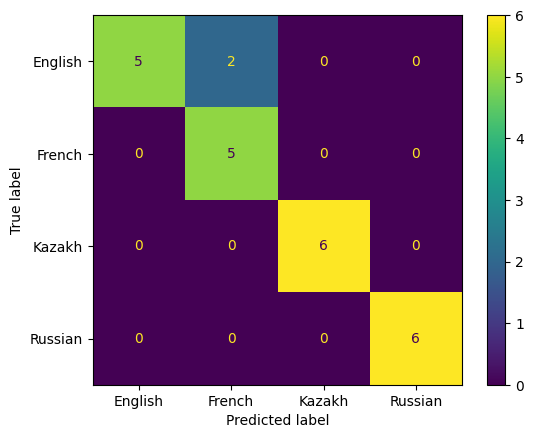

In [119]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_).plot()

In [120]:
new_texts = [
    "Менің атым Айгүл.",
    "It is a wonderful evening.",
    "Je suis très heureux aujourd'hui.",
    "Сегодня отличный день!"
]

new_clean = [re.sub(r'[^a-zа-яёәіңғүұқөһçéèàùòì\s]', '', t.lower()) for t in new_texts]

X_new = vectorizer.transform(new_clean)

preds = model.predict(X_new)

for txt, lang in zip(new_texts, preds):
    print(f"{txt} / {lang}")


Менің атым Айгүл. / Kazakh
It is a wonderful evening. / English
Je suis très heureux aujourd'hui. / French
Сегодня отличный день! / Russian
